# 1. Load saved data from Part 1

The following code assumes the notebook for Part 1 was executed, or the outputs from Part 1 was downloaded from [Google Drive](https://drive.google.com/drive/folders/1zfT8Hlp32RHILd6cNq0CZ3pTM7m1A7vS?usp=sharing) and saved into the mounted Google Drive. It assume there is a folder "facial_recognition" inside the mounted GoogleDrive, and that inside that folder, there are three subfolders: "resources", "results", "weights"

In [0]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


keras version: 2.3.0-tf
X_train: (6000, 96, 96, 1)
Y_train: (6000, 30)


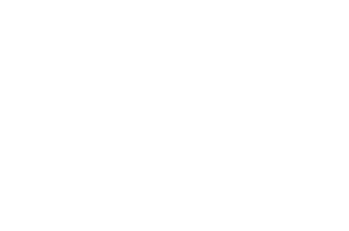

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import pickle

print(f"keras version: {keras.__version__}")
%matplotlib inline
plt.style.use('ggplot')
plt.axis('off')
IMAGE_WIDTH = 96

np.random.seed(0)

# load data
X_train = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_img.pkl", "rb" ) )
Y_train_ffill = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_ffill.pkl", "rb" ) )
Y_train_median = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_median.pkl", "rb" ) )
Y_train_knn = pickle.load( open( "/content/drive/My Drive/facial_recognition/resources/train_kp_knn.pkl", "rb" ) )

print('X_train:', X_train.shape)
print('Y_train:', Y_train_ffill.shape)

# 2. Helper section

In [0]:
# helper function to plot the validation result from the model
def plot_history(history, name):
  plt.figure(figsize=(12,8))

  plt.plot(history['loss'], linewidth=3,color = "red", alpha = 0.8, label='loss')
  plt.plot(history['mae'], linewidth=3,color = "blue", alpha = 0.8, label='mae')

  if 'val_loss' in history:
    plt.plot(history['val_loss'], "--", linewidth=3, color = "red", alpha = 0.8, label='val_loss')
    plt.plot(history['val_mae'], "--", linewidth=3, color = "blue", alpha = 0.8, label='val_mae')
  
  plt.yscale("log")
  plt.xlabel("epoch")
  plt.ylabel("log value")
  plt.title(name)
  plt.legend()
  plt.grid(True)
  plt.show()

# custom callback for training the CNN, saves at each epoch
# tracks minimal val_loss achieved with this variant of model, and 
# places and alert whenever a new minimal occurs
class StopAndSaveCallback(keras.callbacks.Callback): 
  def __init__(self, min_loss, save_path):
    self.min_loss = min_loss
    self.save_path = save_path
  def on_epoch_end(self, epoch, logs):
    # attempt, model, fill_mode are global variables defined later
    self.model.save_weights(f"{self.save_path}/{model}_{fill_mode}_try{attempt}_ep{epoch}.h5")
    if logs["val_loss"] < self.min_loss:
      self.min_loss = logs["val_loss"]
      print(f'lower loss_val, attempt {attempt}, epoch {epoch}')
      print(logs)

# build in early stop call back monitoring val_loss,
# if val_loss does not improve by 0.1 after 5 epochs, terminate training early
stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=0, mode='min')

# 3. LeNet5

In [0]:
def create_naive_LeNet5_model(input_shape):
  # helper function that creates a LeNet5 CNN model, input is an integer indicating the shape of each training input
  model = keras.Sequential()
  model.add(keras.layers.InputLayer(input_shape))
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=30))
  return model


### 3.1 LeNet5 + ffill

In [0]:
model = 'LeNet5'
fill_mode = 'ffill'
ffill_dict = {}

# instantiate a new callback function setting the minimal loss at 1000
# when the model achieves val_loss lower than 1000, the alert will trigger
save_callback_1 = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
  print(f'attempt {attempt}')

  # create and compile a new LeNet model
  LeNet5_model_ffill = create_naive_LeNet5_model(X_train.shape[1:])
  LeNet5_model_ffill.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

  # train for up to 200 epochs and save result
  result_LeNet_ffill = LeNet5_model_ffill.fit(X_train, Y_train_ffill, epochs = 200, batch_size = 256, validation_split = 0.2, verbose = 0, callbacks=[save_callback_1, stop_callback])
  ffill_dict[f'run{attempt}_result'] = result_LeNet_ffill.history

attempt 1
lower loss_val, attempt 1, epoch 0
{'loss': 1124.8631591796875, 'mae': 25.46506690979004, 'val_loss': 237.3878631591797, 'val_mae': 11.978523254394531}
lower loss_val, attempt 1, epoch 1
{'loss': 319.89581298828125, 'mae': 14.122885704040527, 'val_loss': 148.41952514648438, 'val_mae': 9.452439308166504}
lower loss_val, attempt 1, epoch 2
{'loss': 232.25416564941406, 'mae': 11.971771240234375, 'val_loss': 128.04103088378906, 'val_mae': 8.668478012084961}
lower loss_val, attempt 1, epoch 4
{'loss': 168.0032196044922, 'mae': 10.080584526062012, 'val_loss': 106.46622467041016, 'val_mae': 7.836114883422852}
lower loss_val, attempt 1, epoch 5
{'loss': 153.02894592285156, 'mae': 9.560649871826172, 'val_loss': 94.20476531982422, 'val_mae': 7.345538139343262}
lower loss_val, attempt 1, epoch 6
{'loss': 137.3139190673828, 'mae': 9.050296783447266, 'val_loss': 90.65865325927734, 'val_mae': 7.18715238571167}
lower loss_val, attempt 1, epoch 8
{'loss': 122.26512145996094, 'mae': 8.4783020

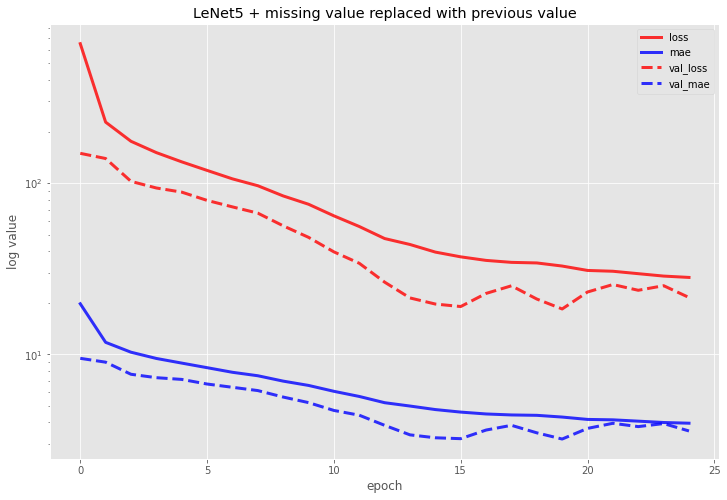

In [0]:
# save the results of the 50 training attempts
pickle.dump( ffill_dict, open( "/content/drive/My Drive/facial_recognition/results/LeNet5_ffill.p", "wb" ) )

# plot the history of the record holder
plot_history(ffill_dict['run26_result'],'LeNet5 + missing value replaced with previous value')

### 3.1 LeNet5 + median

In [0]:
model = 'LeNet5'
fill_mode = 'median'
median_dict = {}

save_callback_2 = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
  print(f'attempt {attempt}')
  LeNet5_model_median = create_naive_LeNet5_model(X_train.shape[1:])
  LeNet5_model_median.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
  result_LeNet_median = LeNet5_model_median.fit(X_train, Y_train_median, epochs = 200, batch_size = 256, validation_split = 0.2, verbose = 0, callbacks=[save_callback_2, stop_callback])
  median_dict[f'run{attempt}_result'] = result_LeNet_median.history

attempt 1
lower loss_val, attempt 1, epoch 0
{'loss': 1420.7003173828125, 'mae': 30.17980194091797, 'val_loss': 359.81072998046875, 'val_mae': 15.065675735473633}
lower loss_val, attempt 1, epoch 1
{'loss': 377.6705322265625, 'mae': 15.334638595581055, 'val_loss': 139.58700561523438, 'val_mae': 9.093975067138672}
lower loss_val, attempt 1, epoch 2
{'loss': 220.05982971191406, 'mae': 11.50492000579834, 'val_loss': 122.71470642089844, 'val_mae': 8.39177417755127}
lower loss_val, attempt 1, epoch 3
{'loss': 175.4010467529297, 'mae': 10.181617736816406, 'val_loss': 110.21907043457031, 'val_mae': 7.879086017608643}
lower loss_val, attempt 1, epoch 4
{'loss': 152.69674682617188, 'mae': 9.47620964050293, 'val_loss': 85.2629165649414, 'val_mae': 6.900124549865723}
lower loss_val, attempt 1, epoch 6
{'loss': 116.9698715209961, 'mae': 8.212607383728027, 'val_loss': 77.91861724853516, 'val_mae': 6.5786590576171875}
lower loss_val, attempt 1, epoch 7
{'loss': 105.39738464355469, 'mae': 7.815126895

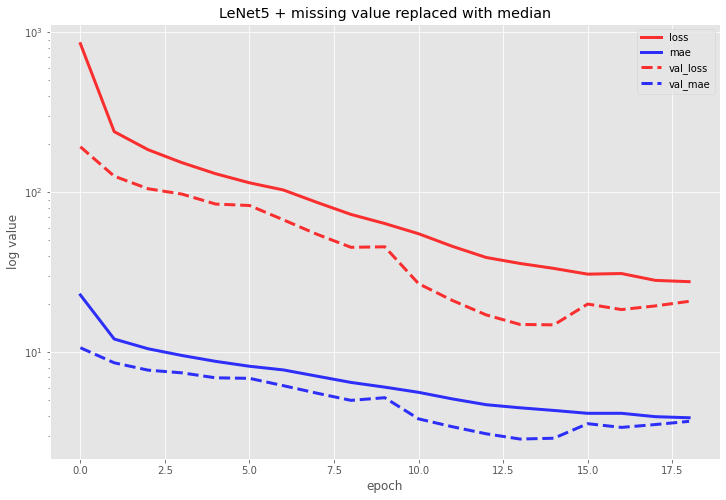

In [0]:
pickle.dump( median_dict, open( "/content/drive/My Drive/facial_recognition/results/LeNet5_median.p", "wb" ) )
plot_history(median_dict['run36_result'],'LeNet5 + missing value replaced with median')

### 3.3 LeNet5 + KNN

In [0]:
model = 'LeNet5'
fill_mode = 'knn'
knn_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=0, mode='min')
save_callback_3 = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
  print(f'attempt {attempt}')
  LeNet5_model_knn = create_naive_LeNet5_model(X_train.shape[1:])
  LeNet5_model_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
  result_LeNet_knn = LeNet5_model_knn.fit(X_train, Y_train_knn, epochs = 200, batch_size = 256, validation_split = 0.2, verbose = 0, callbacks=[save_callback_3, stop_callback])
  knn_dict[f'run{attempt}_result'] = result_LeNet_knn.history

attempt 1
lower loss_val, attempt 1, epoch 0
{'loss': 886.4322509765625, 'mae': 23.175832748413086, 'val_loss': 175.84176635742188, 'val_mae': 10.214804649353027}
lower loss_val, attempt 1, epoch 1
{'loss': 263.3638000488281, 'mae': 12.73221206665039, 'val_loss': 111.9202651977539, 'val_mae': 8.020021438598633}
lower loss_val, attempt 1, epoch 2
{'loss': 184.5964813232422, 'mae': 10.560144424438477, 'val_loss': 105.82015228271484, 'val_mae': 7.720963478088379}
lower loss_val, attempt 1, epoch 3
{'loss': 149.69288635253906, 'mae': 9.454023361206055, 'val_loss': 85.4194107055664, 'val_mae': 6.918581485748291}
lower loss_val, attempt 1, epoch 4
{'loss': 122.90667724609375, 'mae': 8.536813735961914, 'val_loss': 73.76554870605469, 'val_mae': 6.461308002471924}
lower loss_val, attempt 1, epoch 5
{'loss': 108.79219818115234, 'mae': 8.004145622253418, 'val_loss': 69.62322235107422, 'val_mae': 6.280166149139404}
lower loss_val, attempt 1, epoch 7
{'loss': 96.43492126464844, 'mae': 7.48664712905

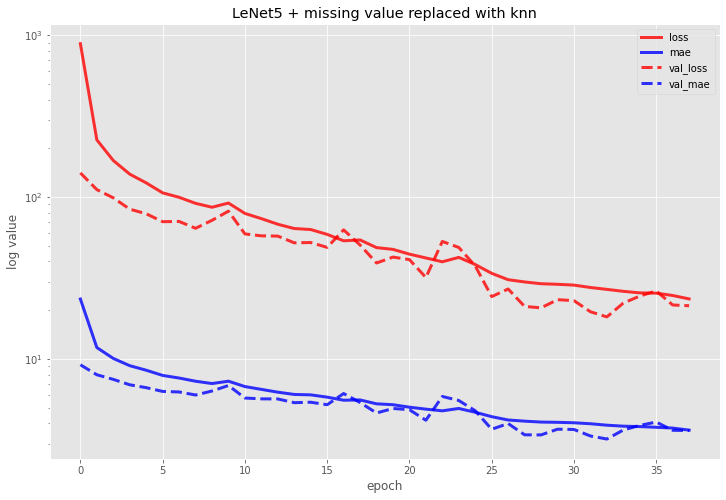

In [0]:
pickle.dump( knn_dict, open( "/content/drive/My Drive/facial_recognition/results/LeNet5_knn.p", "wb" ) )
plot_history(knn_dict['run40_result'],'LeNet5 + missing value replaced with knn')

# 4. VGG16

In [0]:
def create_vgg16_model_single_channel(input_shape, use_imagenet = False):
  # convert the grayscale input layer to rgb channels
  single_channel_input = keras.layers.Input(shape=input_shape)
  single_channel_concat = keras.layers.concatenate([single_channel_input,single_channel_input,single_channel_input])

  # load VGG16, either with or without pre_trained weights from ImageNet
  if use_imagenet:
    model_layer = keras.applications.VGG16(weights="imagenet", include_top=False)(single_channel_concat)
  else:
    model_layer = keras.applications.VGG16(weights=None, include_top=False)(single_channel_concat)

  # Flatten the output layer to 1 dimension
  x = keras.layers.Flatten()(model_layer)

  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = keras.layers.Dense(1024, activation='relu')(x)

  # Add a dropout rate of 0.2
  x = keras.layers.Dropout(0.2)(x)

  # Add a final sigmoid layer for classification
  x = keras.layers.Dense (30)(x) 
  model = keras.Model(single_channel_input, x) 
  return model

### 4.1 VGG 16 + no weight + knn

In [0]:
model = 'VGG16'
fill_mode = 'knn'
knn_vgg_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=0, mode='min')
save_callback_4 = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/facial_recognition/weights')

for attempt in range(1, 51):
  print(f'attempt {attempt}')
  VGG16_model_knn = create_vgg16_model_single_channel(X_train.shape[1:])
  VGG16_model_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
  result_VGG_knn = VGG16_model_knn.fit(X_train, Y_train_knn, epochs = 200, batch_size = 256, validation_split = 0.2, verbose = 0, callbacks=[save_callback_4, stop_callback])
  knn_vgg_dict[f'run{attempt}_result'] = result_VGG_knn.history

attempt 1
lower loss_val, attempt 1, epoch 2
{'loss': 652.5817260742188, 'mae': 20.68427276611328, 'val_loss': 241.90011596679688, 'val_mae': 11.786357879638672}
lower loss_val, attempt 1, epoch 3
{'loss': 235.7758331298828, 'mae': 12.061975479125977, 'val_loss': 112.67105865478516, 'val_mae': 7.997382640838623}
lower loss_val, attempt 1, epoch 5
{'loss': 160.41079711914062, 'mae': 9.8751859664917, 'val_loss': 97.73274993896484, 'val_mae': 7.409165859222412}
lower loss_val, attempt 1, epoch 6
{'loss': 148.45323181152344, 'mae': 9.483718872070312, 'val_loss': 89.84663391113281, 'val_mae': 7.117105484008789}
lower loss_val, attempt 1, epoch 8
{'loss': 125.00328826904297, 'mae': 8.680743217468262, 'val_loss': 78.14028930664062, 'val_mae': 6.64524507522583}
lower loss_val, attempt 1, epoch 11
{'loss': 102.00363159179688, 'mae': 7.810332775115967, 'val_loss': 61.58905029296875, 'val_mae': 5.878856658935547}
lower loss_val, attempt 1, epoch 13
{'loss': 80.64447784423828, 'mae': 6.93813085556

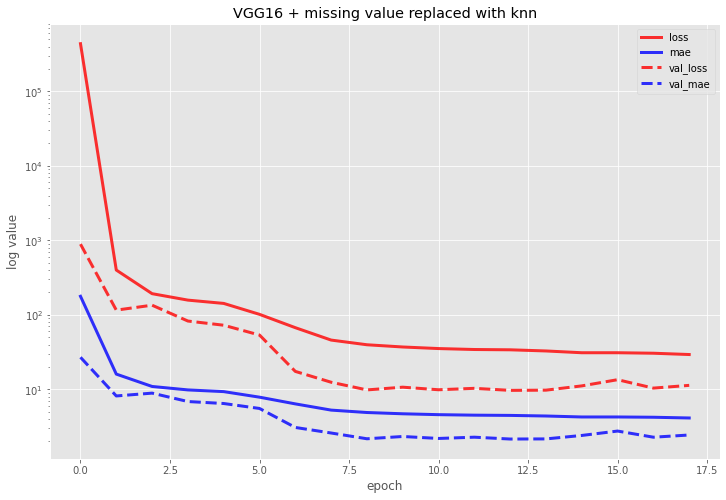

In [0]:
pickle.dump( knn_vgg_dict, open( "/content/drive/My Drive/facial_recognition/results/VGG16_knn.p", "wb" ) )
plot_history(knn_vgg_dict['run8_result'],'VGG16 + missing value replaced with knn')

### 4.2 VGG 16 + ImageNet + knn

In [0]:
model = 'VGG16_imagenet'
mode = 'knn'
knn_vgg_imgnet_dict = {}

stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=5, verbose=0, mode='min')
save_callback_5 = StopAndSaveCallback(min_loss = 1000, save_path = '/content/drive/My Drive/FacialRecognition/vgg_knn_imagenet')

for attempt in range(1, 51):
  print(f'attempt {attempt}')
  VGG16_imagenet_model_knn = create_vgg16_model_single_channel(X_train.shape[1:], True)
  VGG16_imagenet_model_knn.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])
  result_VGG_imgnet_knn = VGG16_imagenet_model_knn.fit(X_train, Y_train_knn, epochs = 200, batch_size = 256, validation_split = 0.2, verbose = 0, callbacks=[save_callback_5, stop_callback])
  knn_vgg_imgnet_dict[f'run{attempt}_result'] = result_VGG_imgnet_knn.history

attempt 1
lower loss_val, attempt 1, epoch 0
{'loss': 7379.61083984375, 'mae': 54.54715347290039, 'val_loss': 840.9124145507812, 'val_mae': 26.056678771972656}
lower loss_val, attempt 1, epoch 1
{'loss': 308.4457702636719, 'mae': 13.708104133605957, 'val_loss': 123.23561096191406, 'val_mae': 8.460447311401367}
lower loss_val, attempt 1, epoch 3
{'loss': 165.73492431640625, 'mae': 10.00268268585205, 'val_loss': 117.28656005859375, 'val_mae': 8.189446449279785}
lower loss_val, attempt 1, epoch 5
{'loss': 149.9751739501953, 'mae': 9.498210906982422, 'val_loss': 104.0691909790039, 'val_mae': 7.714234352111816}
lower loss_val, attempt 1, epoch 6
{'loss': 140.5763702392578, 'mae': 9.143282890319824, 'val_loss': 100.3354721069336, 'val_mae': 7.57045316696167}
lower loss_val, attempt 1, epoch 8
{'loss': 139.12496948242188, 'mae': 9.055529594421387, 'val_loss': 95.9710922241211, 'val_mae': 7.412739276885986}
lower loss_val, attempt 1, epoch 11
{'loss': 117.88949584960938, 'mae': 8.3383035659790

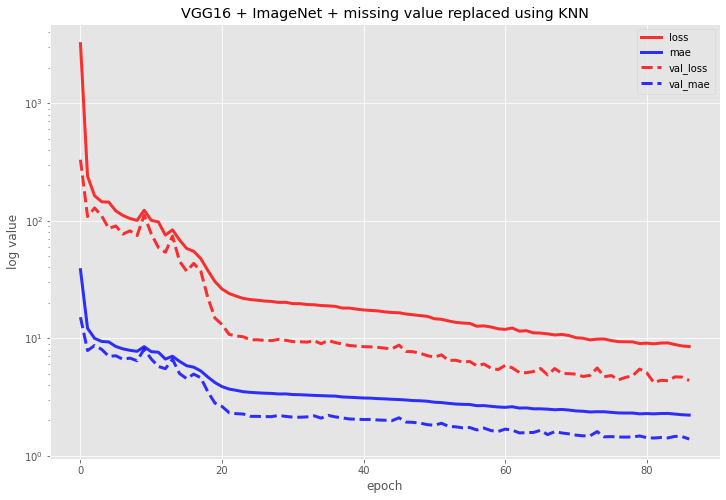

In [0]:
plot_history(knn_vgg_imgnet_dict['run33_result'],'VGG16 + ImageNet + missing value replaced using KNN')
pickle.dump( knn_vgg_imgnet_dict, open( "/content/drive/My Drive/facial_recognition/results/VGG16_imagenet_knn.p", "wb" ) )